# Miguel Ángel García Ruíz

# Taller 4: Selección TTbar semileptonico

# An introductional notebook to HEP analysis in C++

<p>In this notebook you can find an easy set of commands that show some basic computing techniques commonly used in High Energy Physics (HEP) analyzes.</p>

<p>It also shows how to create an histogram, fill it and draw it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. The final output is a plot with the number of leptons.</p>

Based on ATLAS opendata notebooks (http://opendata.atlas.cern/release/2020/documentation/notebooks/intro.html)


The library used is [ROOT](https://root.cern.ch/), a scientific data analysis software framework that provides a large set of functionalities needed to deal with big data processing, statistical analysis, visualisation and storage.

<p>At first we have to include several helpers that will support our analysis:</p>

In [1]:
#include <iostream>
#include <string>
#include <stdio.h>

Next we have to open the data that we want to analyze. As described above the data is stored in a _*.root_ file. This is a root file containing tracks and calorimeter clusters

In [2]:
//TFile *file = TFile::Open("Data_8TeV.root"); 
TFile *file = TFile::Open("http://csandova.web.cern.ch/csandova/HEP-Ex-Course/Code/TTbarSel/Data_8TeV.root"); 

The next step is to define a tree named _tree_ to get the data out of the _*.root_ file. The tree in this root file is called "JetRecoTree". We will then print the contents of the tree to find the names of the variables. 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries : 14945674 : Total =      3737586466 bytes  File  Size = 1366006484 *
*        :          : Tree compression factor =   2.74                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries : 14945674 : Total  Size=   59789737 bytes  File Size  =     297928 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression= 200.68     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries : 14945674 : Total  Size=   59789885 bytes  File Size  =   44412272 *
*Baskets :       70 : Basket Size=    1224192 bytes  Compression=   1.35     *
*...................................................

Activate variables 

In [4]:
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

Float_t jet_pt[10];  
Float_t jet_eta[10];
Float_t jet_phi[10];
Float_t jet_jvf[10];
Float_t jet_mv1[10];
Float_t evtw;

tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_phi", &jet_phi);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_mv1);
tree->SetBranchAddress("mcWeight", &evtw);

Create Canvas

In [5]:
TCanvas *canvas = new TCanvas("canvas","canvas",800,600);
//gSystem->Unlink("Distribution_plots.gif");

Create histograms: Leading jet pT and all jets pT 

In [6]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);
TH1F *hist_leptons_pT = new TH1F("Leptons pT", "Leptons pT Distribution; pT [GeV]; Events", 130, 0, 130);
TH1F *hist_lep_track_isolation = new TH1F("Track isolation", "Track Isolation Distribution; track isolation; Events", 100, 0, 0.5);
TH1F *hist_lep_calor_isolation = new TH1F("Calorimeter isolation", "Calorimeter Isolation Distribution; calorimeter isolation; Events", 100, 0, 0.5);
TH1F *hist_lep_eta = new TH1F("Lepton eta", "Lepton #eta Distribution; #eta; Events", 100, -3, 3);
TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);
TH1F *hist_jets_pT = new TH1F("Jets pT", "Jets pT Distribution; pT [GeV]; Events", 100, 0, 200);
TH1F *hist_jets_eta = new TH1F("Jets eta", "Jets #eta Distribution; #eta; Events", 100, -3, 3);
TH1F *hist_jets_jvf = new TH1F("Jets jvf", "JVF Distribution; jvf; Events", 100, 0, 1);
TH1F *hist_jets_mv1 = new TH1F("Jets MV1", "Jets MV1 Distribution; mv1; Events", 100, 0, 1);
TH1F *hist_bjets = new TH1F("bjets", "b-Jets Distribution; b-jets; Events", 5, 0, 5);
TH1F *hist_MET = new TH1F("MET hist", "MET Distribution; MET [GeV]; Events", 100, 0, 200);
TH1F *hist_mTw = new TH1F("mTW hist", "mT(W) Distribution; mT(W) [GeV]; Events", 100, 0, 200);

Loop and fill histograms

In [7]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;


for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
        
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;
    unsigned int goodlep_index=0;
    
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        
        hist_leptons_pT->Fill(lep_pt[i]/1000.);//Fill lepton pT distribution before applying cut of good leptons
        hist_lep_track_isolation->Fill(lep_ptcone30[i]/lep_pt[i]);//Fill track isolation before applying cut of good leptons
        hist_lep_calor_isolation->Fill(lep_etcone20[i]/lep_pt[i]);//Fill calorimeter isolation before applying cut of good leptons
        hist_lep_eta->Fill(lep_eta[i]);//Fill eta distribution before applying cut of good leptons
        
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type[i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;}
        /*
        To complete: Add electrons and extract the index for the good lepton
        */        
        //////////////
        if( lep_type[i]==11 && TMath::Abs(lep_eta[i]) < 2.47 && (TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52) ){
            n_el++;}
        //////////////
   
        goodlep_index=i;        
        n_lep++;
        }
    //n_lep = n_mu + n_el;
    
     //Select events with only 1 good lepton and fill the cutflow histogram 
    //Example:
    //Third cut (one good lepton):
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
  
    
    int n_goodjets=0;
    int n_bjets=0;
    
    //Number of jets distribution
    hist_njets->Fill(jet_n);
    
    for(unsigned int i=0; i<jet_n; i++)
    {
        hist_jets_pT->Fill(jet_pt[i]/1000.);//Fill jet pT distribution before applying cut of at least 4 jets
        hist_jets_eta->Fill(jet_eta[i]);//Fill jet eta distribution before applying cut of at least 4 jets
        hist_jets_jvf->Fill(jet_jvf[i]);//Fill jet jvf distribution before applying cut of at least 4 jets
        hist_jets_mv1->Fill(jet_mv1[i]);//Fill jet mv1 distribution before applying cut of at least 4 jets
    }
    
    //Fourth cut: At least 4 jets
    if(jet_n<4) continue; 
    cutflow->Fill(4); 
    cut4++;

    for(unsigned int j=0; j<jet_n; j++){
        // To complete: apply jet cuts to find the good jets
        //pT cut
        if(jet_pt[j] <= 25000.) continue;
        
        //Eta cut
        //////////////////////////////////
        if(TMath::Abs(jet_eta[j]) >= 2.5) continue;
        //////////////////////////////////
        
        // JVF cleaning    
        ////////////////////////////////// pT<50GeV => (|eta|<2.4 and |JVF|>0.5)
       
        if(jet_pt[j] < 50000.)
        {
            if(TMath::Abs(jet_eta[j]) >= 2.4 || TMath::Abs(jet_jvf[j]) <= 0.5){
                continue;
            }
        }
        //////////////////////////////////
        
        n_goodjets++;
        
        // cut on 0.7892 MV1 and count the number of b-jets
        //////////////////////////////////
        if(jet_mv1[j] < 0.7892) continue;
        //////////////////////////////////
        
        n_bjets++;
        }
    
    hist_bjets->Fill(n_bjets);//Fill number of bjets distribution before applying cut of at least 4 good jets
    
    
    //Fifth cut: At least 4 good jets
    if(n_goodjets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    
    //Sixth cut: at least two b-jet 
    if(n_bjets<2) continue;
    /////////////////////////////////////////////////
    //cutflow
    cutflow->Fill(6);
    cut6++;
    /////////////////////////////////////////////////
    
    hist_MET->Fill(MET/1000.); //Fill Missing Energy Transverse before applying cut of MET>30GeV
    
    //Seventh cut: MET > 30 GeV
    if(MET<30000.) continue;
    /////////////////////////////////////////////////
    //cutflow
    cutflow->Fill(7);
    cut7++;
    /////////////////////////////////////////////////
    
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();

    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    ///////////////////////////////////////////////////////////
    
    Lepton.SetPtEtaPhiE(lep_pt[goodlep_index], lep_eta[goodlep_index], lep_phi[goodlep_index], lep_E[goodlep_index]);

    MeT.SetPtEtaPhiE(MET, 0, MET_phi , MET);
    
    //Calculation of the mTW using TLorentz vectors             
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    
    hist_mTw->Fill(mTW/1000.);//Fill mTW before applying cut of mTW>30GeV

    //Eight cut: mTW > 30 GeV
    /////////////////////////////////////////////////
    if(mTW <= 30000.) continue;
    cutflow->Fill(8);
    cut8++;
    
}

std::cout << "Done!" << std::endl;
std::cout << "All events:              " << nentries << std::endl;
std::cout << "Cut1: One good vertex:   " << cut1 << std::endl;
std::cout << "Cut2: Trigger 1 lep:     " << cut2 << std::endl;
std::cout << "Cut3: 1 good lepton:     " << cut3 << std::endl;
std::cout << "Cut4: At leats 4 jets:   " << cut4 << std::endl;
std::cout << "Cut5: At least 4 gjets:  " << cut5 << std::endl;
std::cout << "Cut6: At least 2 b jets: " << cut6 << std::endl;
std::cout << "Cut7: MET > 30 GeV:      " << cut7 << std::endl;
std::cout << "Cut8: mTW > 30 GeV:      " << cut8 << std::endl;

std::cout << "Done!" << endl;

Done!
All events:              14945674
Cut1: One good vertex:   14656440
Cut2: Trigger 1 lep:     14656440
Cut3: 1 good lepton:     11561801
Cut4: At leats 4 jets:   61995
Cut5: At least 4 gjets:  59797
Cut6: At least 2 b jets: 10655
Cut7: MET > 30 GeV:      8451
Cut8: mTW > 30 GeV:      7093
Done!


<p>Draw</p>

In [8]:
TCanvas *canvas = new TCanvas("canvas","canvas",800,600);

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


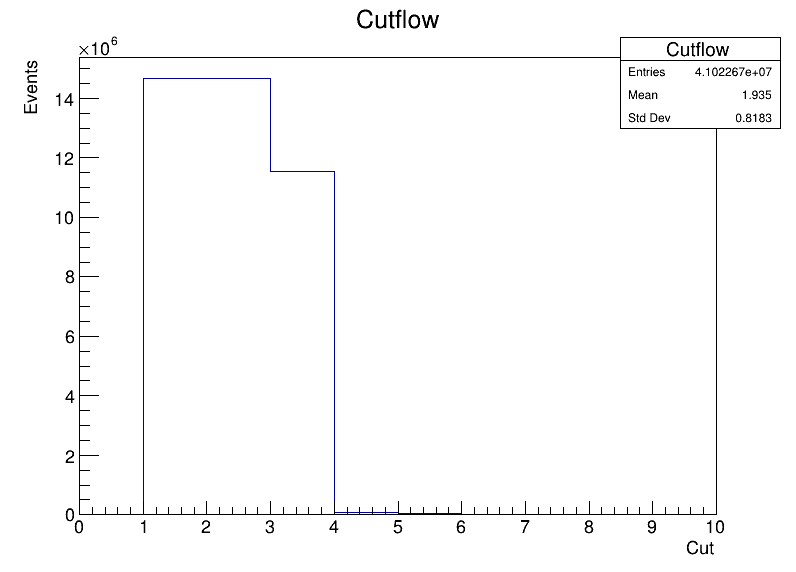

In [9]:
cutflow->Draw("");
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

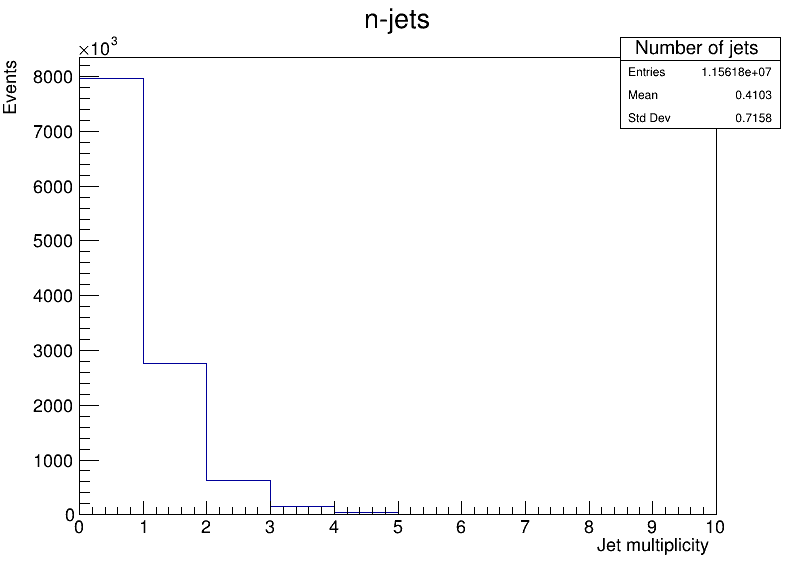

In [10]:
hist_njets->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

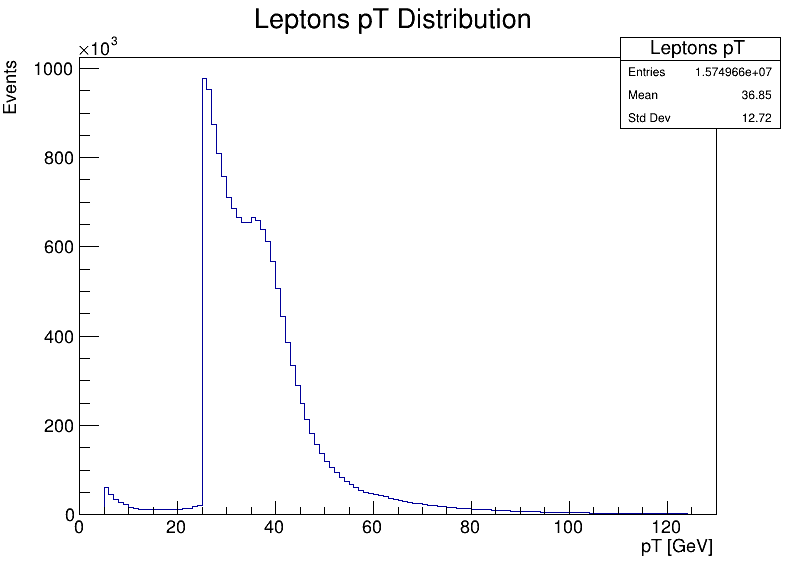

In [11]:
hist_leptons_pT->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

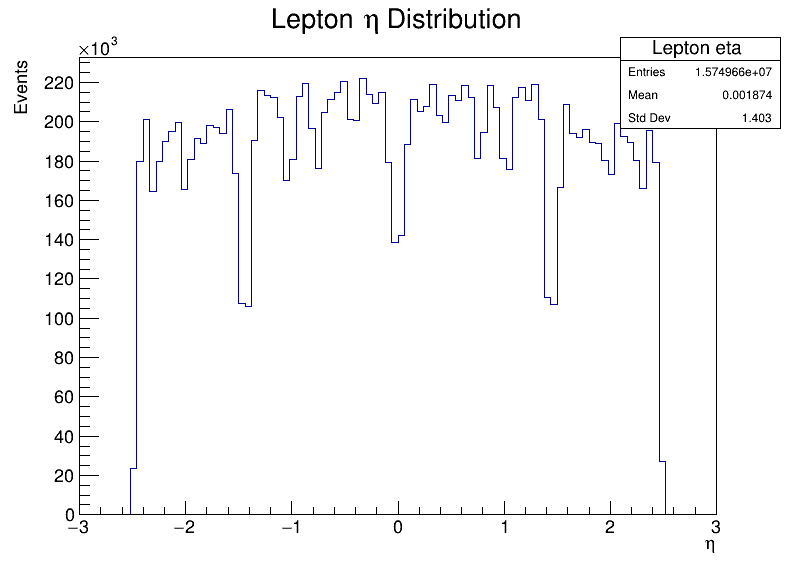

In [12]:
hist_lep_eta->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

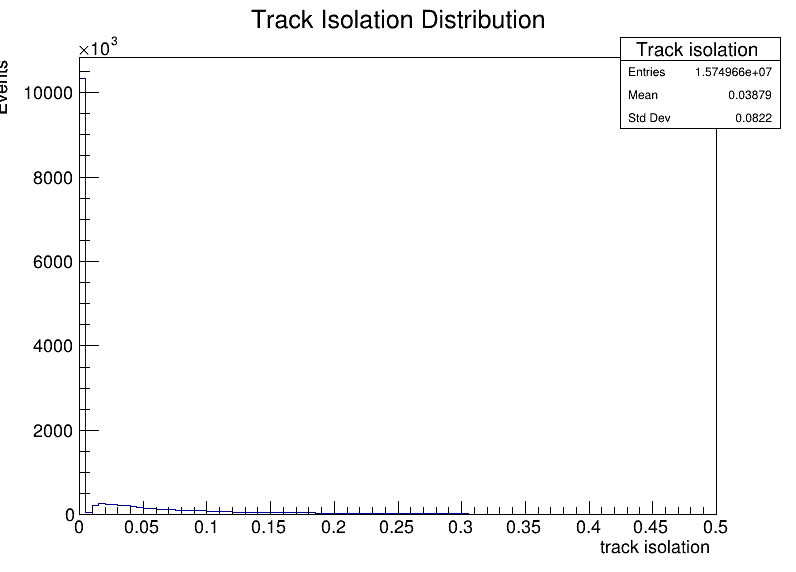

In [13]:
hist_lep_track_isolation->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

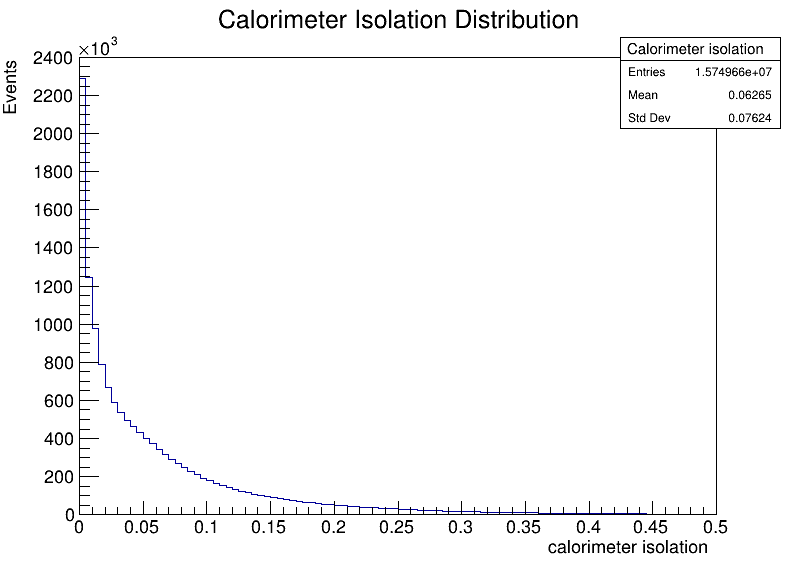

In [14]:
hist_lep_calor_isolation->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

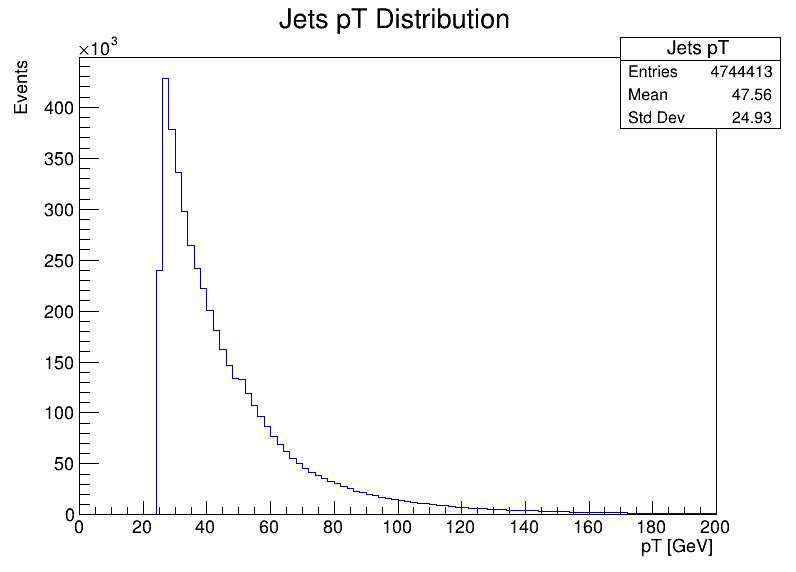

In [15]:
hist_jets_pT->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

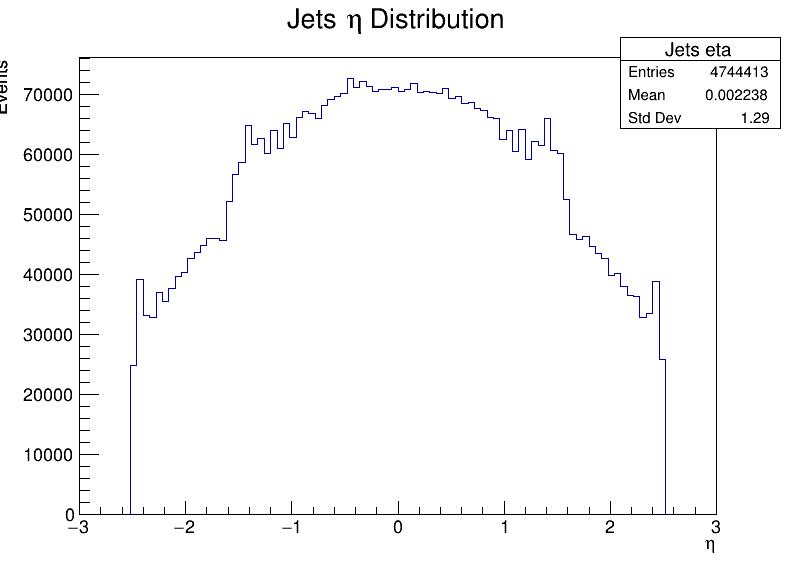

In [16]:
hist_jets_eta->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

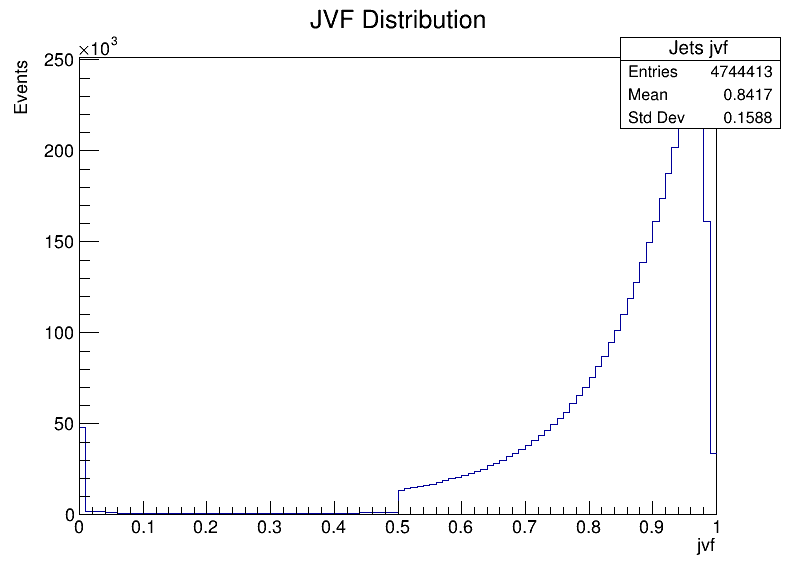

In [17]:
hist_jets_jvf->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

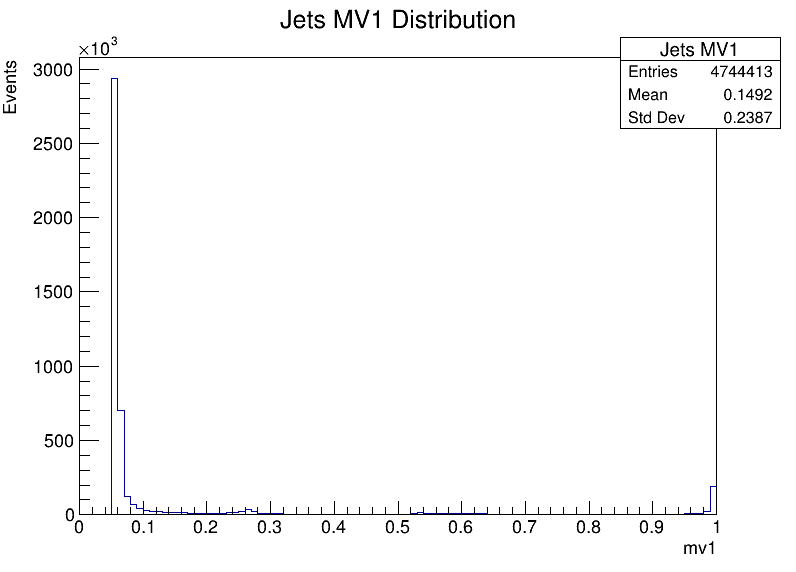

In [18]:
hist_jets_mv1->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

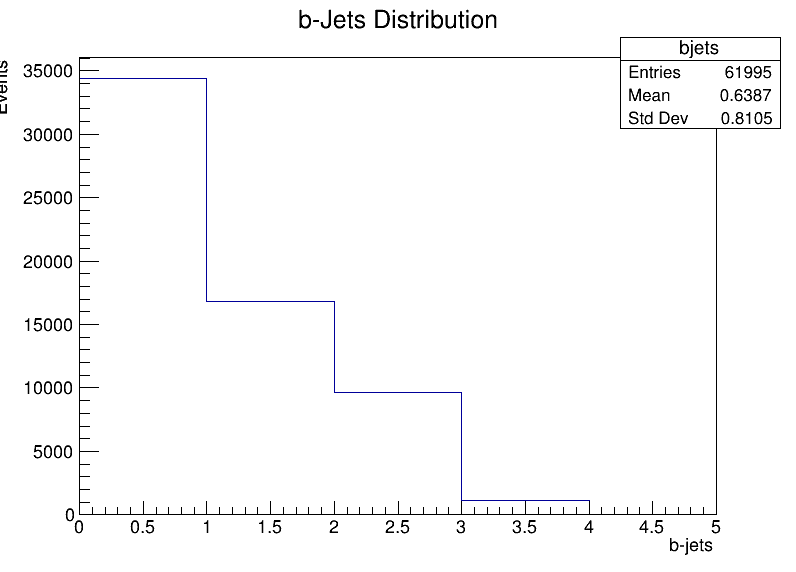

In [19]:
hist_bjets->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

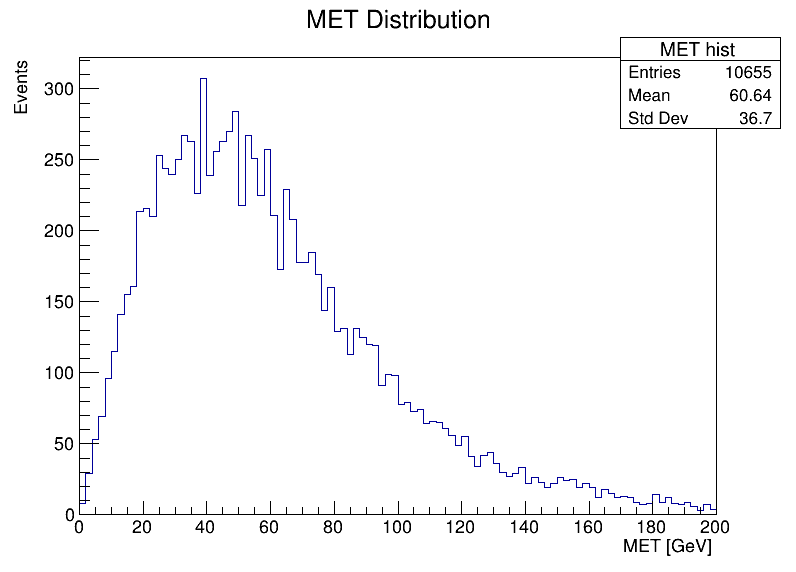

In [20]:
hist_MET->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/

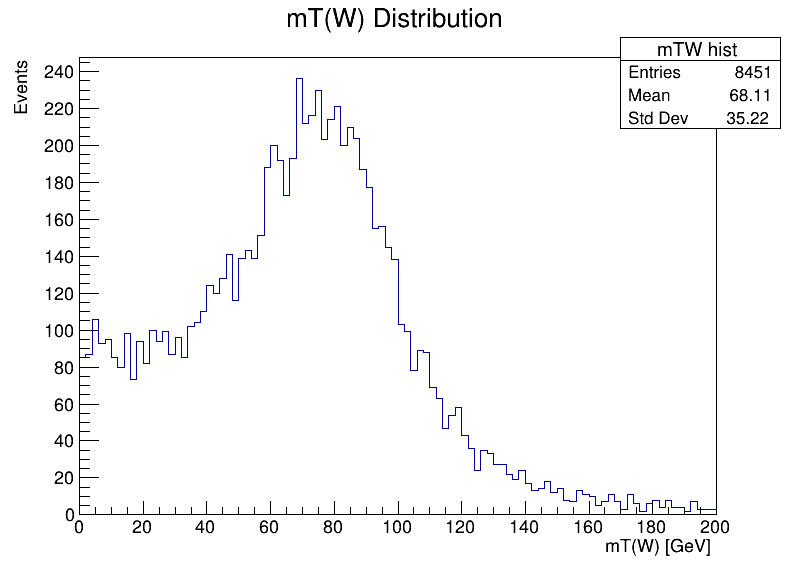

In [21]:
hist_mTw->Draw();
canvas->Draw();
/*
canvas->Update();
sleep(10);
canvas->Print("Distribution_plots.gif+");
*/